# Tree Sampling Divergence

This notebook presents the experiments of the following paper:

Tree Sampling Divergence: An Information-Theoretic Metric for Hierarchical Graph Clustering<br>
Bertrand Charpentier, Thomas Bonald<br>
IJCAI 2019

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score, roc_auc_score

from utilities import HSBM, rank_score, shuffle_edges, clustering_from_dendrogram, load_dataset
from plot_tools import plot_graph, plot_graph_clustering, plot_dendrogram, plot_dendrogram_clustering
from agglomerative_algorithms import agglomerative_clustering

from hierarchical_metrics import euclidean, dasgupta, tsd
from hierarchy_compression import compress_hierarchy

# Experiment 1: Graph representation

In [2]:
# TODO

# Experiment 2: Graph reconstruction

### Reconstruction score from hierarchy

In [3]:
def reconstruct_from_hierarchy(graph, dendrogram):
    graph_copy = graph.copy()
    n_nodes = np.shape(dendrogram)[0] + 1
    reconstructed_score = np.zeros((n_nodes, n_nodes))

    w = {u: 0 for u in range(n_nodes)}
    wtot = 0
    for (u, v) in graph_copy.edges():
        weight = graph_copy[u][v]['weight']
        w[u] += weight
        w[v] += weight
        wtot += 2 * weight
    p = {u: w[u] / float(wtot) for u in range(n_nodes)}
    c = {u: [u] for u in range(n_nodes)}
    
    pi = {t: w[t] / float(wtot) for t in range(n_nodes)}
    
    u = n_nodes
    for t in range(n_nodes - 1):
        a = int(dendrogram[t][0])
        b = int(dendrogram[t][1])
        
        w[u] = w.pop(a) + w.pop(b)
        pi[u] = w[u] / float(wtot)
        pi_a = pi[a]
        pi_b = pi[b]
        if graph_copy.has_edge(a, b):
            p_ab = 2 * graph_copy[a][b]['weight'] / float(wtot)
        else:
            p_ab = 0
        
        for i in c[a]:
            for j in c[b]:
                reconstructed_score[i, j] = p[i] * p[j] * p_ab / (pi_a * pi_b)
                reconstructed_score[j, i] = reconstructed_score[i, j]
        c[u] = c.pop(a) + c.pop(b)

        # Update graph
        graph_copy.add_node(u)
        neighbors_a = list(graph_copy.neighbors(a))
        neighbors_b = list(graph_copy.neighbors(b))
        for v in neighbors_a:
            graph_copy.add_edge(u, v, weight=graph_copy[a][v]['weight'])
        for v in neighbors_b:
            if graph_copy.has_edge(u, v):
                graph_copy[u][v]['weight'] += graph_copy[b][v]['weight']
            else:
                graph_copy.add_edge(u, v, weight=graph_copy[b][v]['weight'])
        graph_copy.remove_node(a)
        graph_copy.remove_node(b)

        u += 1    

    return reconstructed_score / np.sum(reconstructed_score)

### Hierarchical algorithms

In [4]:
hierarchical_algorithms = {'single': lambda graph: agglomerative_clustering(graph, linkage='single'), 
                          'average': lambda graph: agglomerative_clustering(graph, linkage='average'),
                          'complete': lambda graph: agglomerative_clustering(graph, linkage='complete'),
                          'weighted': lambda graph: agglomerative_clustering(graph, linkage='weighted')}

### Run

In [15]:
clean_hsbm = HSBM.balanced(n_levels=3, decay_factor=.3, division_factor=2, core_community_size=20, p_in=.9)
real_graph = clean_hsbm.create_graph(distribution='Binomial')
print(nx.info(real_graph))
n_nodes = real_graph.number_of_nodes()
adj_true = np.reshape(nx.to_numpy_array(real_graph), n_nodes * n_nodes).astype(bool).astype(int)

Name: 
Type: Graph
Number of nodes: 160
Number of edges: 2191
Average degree:  27.3875


In [16]:
aps, auc, rank = [], [], []
euc, das, tsds = [], [], []
for algo_name, algo in hierarchical_algorithms.items():
    for p in np.linspace(0., 1., num=100):
        shuffled_graph = shuffle_edges(real_graph, p)
        d = algo(shuffled_graph)

        reconstructed_adj = reconstruct_from_hierarchy(real_graph, d)
        adj_score = np.reshape(reconstructed_adj, n_nodes * n_nodes)

        aps.append(average_precision_score(adj_true, adj_score))
        auc.append(roc_auc_score(adj_true, adj_score))
        rank.append(rank_score(real_graph, reconstructed_adj))

        tsds.append(tsd(real_graph, d))
        das.append(dasgupta(real_graph, d))
        euc.append(euclidean(real_graph, d))
        
auc = np.array(auc)
aps = np.array(aps)
rank = np.array(rank)/n_nodes
tsds = np.array(tsds)
das = np.array(das)
euc = np.array(euc)

### Plots

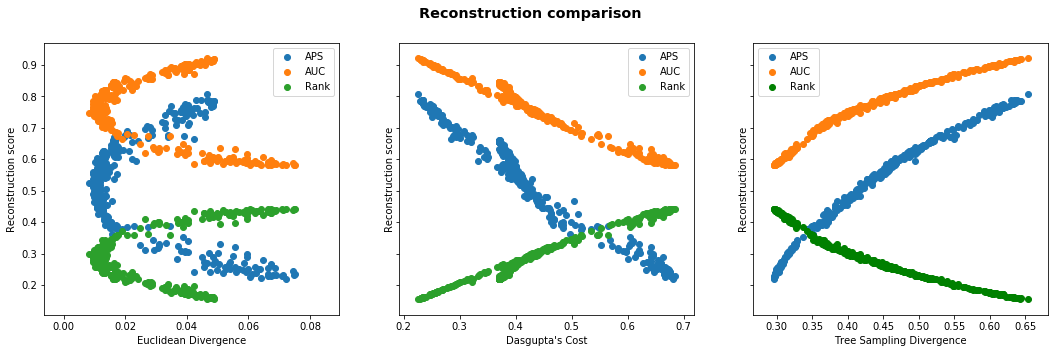

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

axs[0].scatter(euc, aps, label="APS")
axs[0].scatter(euc, auc, label="AUC")
axs[0].scatter(euc, rank, label="Rank")
axs[0].legend()
axs[0].set_xlabel('Euclidean Divergence')
axs[0].set_ylabel('Reconstruction score')

axs[1].scatter(das, aps, label="APS")
axs[1].scatter(das, auc, label="AUC")
axs[1].scatter(das, rank, label="Rank")
axs[1].legend()
axs[1].set_xlabel('Dasgupta\'s Cost')
axs[1].set_ylabel('Reconstruction score')

axs[2].scatter(tsds, aps, label="APS")
axs[2].scatter(tsds, auc, label="AUC")
axs[2].scatter(tsds, rank, label="Rank", color='g')
axs[2].legend()
axs[2].set_xlabel('Tree Sampling Divergence')
axs[2].set_ylabel('Reconstruction score')

fig.suptitle('Reconstruction comparison', fontsize='x-large', fontweight='bold')

plt.show()

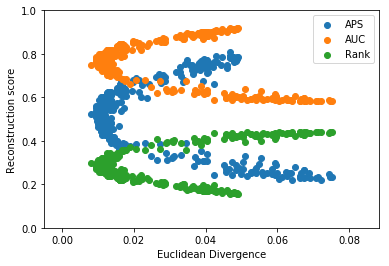

In [24]:
plt.scatter(euc, aps, label="APS")
plt.scatter(euc, auc, label="AUC")
plt.scatter(euc, rank, label="Rank")
plt.ylim(0,1)
plt.legend()
plt.xlabel('Euclidean Divergence')
plt.ylabel('Reconstruction score')
plt.savefig('euc-score.pdf', bbox_inches='tight')

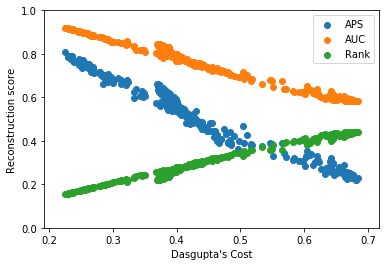

In [25]:
plt.scatter(das, aps, label="APS")
plt.scatter(das, auc, label="AUC")
plt.scatter(das, rank, label="Rank")
plt.ylim(0,1)
plt.legend()
plt.xlabel('Dasgupta\'s Cost')
plt.ylabel('Reconstruction score')
plt.savefig('das-score.pdf', bbox_inches='tight')

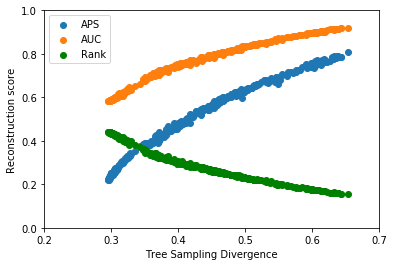

In [27]:
plt.scatter(tsds, aps, label="APS")
plt.scatter(tsds, auc, label="AUC")
plt.scatter(tsds, rank, label="Rank", color='g')
plt.ylim(0,1)
plt.xlim(.2,.7)
plt.legend()
plt.xlabel('Tree Sampling Divergence')
plt.ylabel('Reconstruction score')
plt.savefig('tds-score.pdf', bbox_inches='tight')

# Experiment 3: Graph compression

### Compression: HSBM

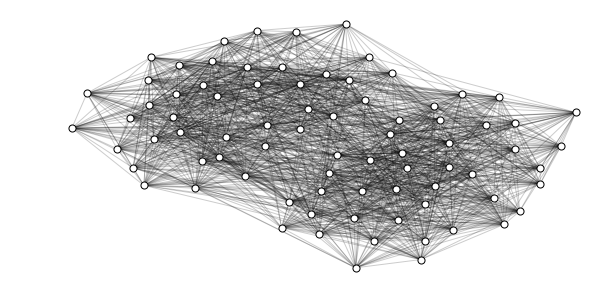

In [8]:
hsbm = HSBM.balanced(n_levels=2, decay_factor=.5, division_factor=2, core_community_size=20, p_in=1.)
hsbm_graph = hsbm.create_graph(distribution='Binomial')
pos = nx.spring_layout(hsbm_graph)
plot_graph(hsbm_graph, pos)

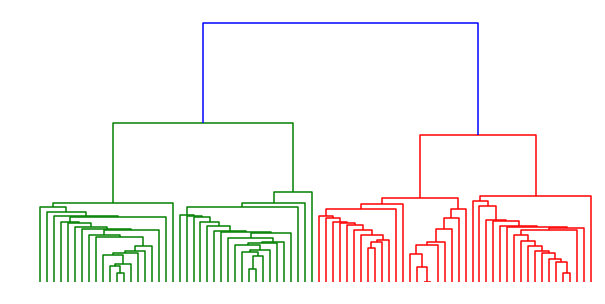

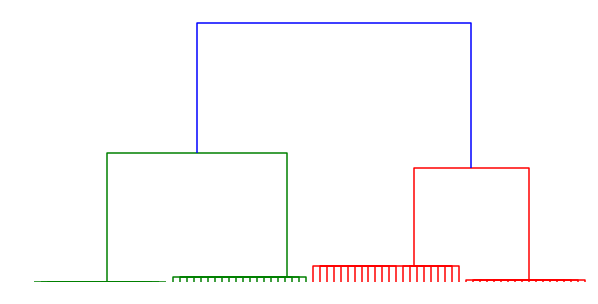

In [9]:
hsbm_dendrogram = agglomerative_clustering(hsbm_graph, linkage='weighted')
plot_dendrogram(hsbm_dendrogram)

hsbm_compressed = compress_hierarchy(hsbm_graph, hsbm_dendrogram, 72)
plot_dendrogram(hsbm_compressed)

### Compression : OpenFlights

Download dataset: https://perso.telecom-paristech.fr/bonald/graphs/openflights.graphml.gz

In [2]:
openflight_graph = nx.read_graphml("../datasets/openflights.graphml")
openflight_graph = nx.convert_node_labels_to_integers(openflight_graph)
pos = {u: (openflight_graph.node[u]['pos_x'], openflight_graph.node[u]['pos_y']) for u in openflight_graph.nodes}
print(nx.info(openflight_graph))

Name: Openflights
Type: Graph
Number of nodes: 3097
Number of edges: 18193
Average degree:  11.7488


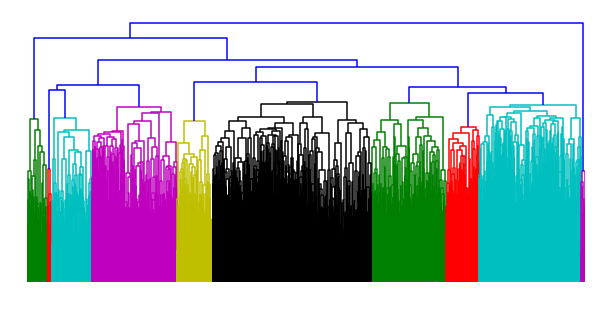

In [3]:
openflight_dendrogram = agglomerative_clustering(openflight_graph, linkage='weighted')
plot_dendrogram(openflight_dendrogram)

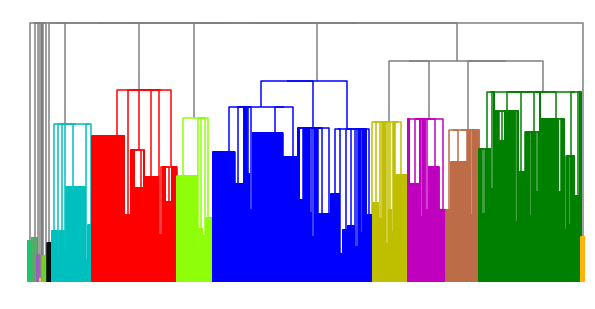

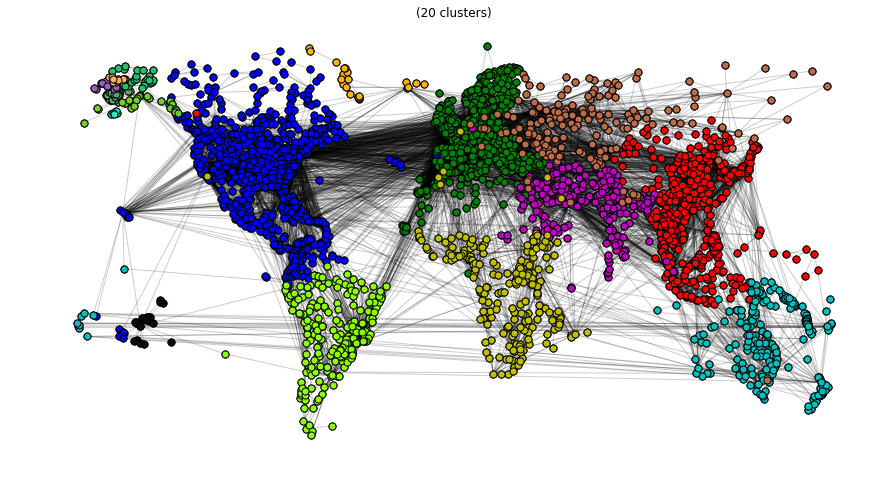

In [4]:
openflight_compressed = compress_hierarchy(openflight_graph, openflight_dendrogram, 3000)
clustering =  clustering_from_dendrogram(openflight_compressed, openflight_graph.number_of_nodes() - 20)
plot_dendrogram_clustering(openflight_compressed, clustering)
plot_graph_clustering(openflight_graph, clustering, pos)